# Set Up

## Importing Libraries

In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import cv2

In [81]:
tf.__version__

'2.15.0'

In [82]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Extra

# Data Collection/Preprocessing

## Collecting Data

In [83]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [84]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/10.jpeg,0,0,1,0,0
1,outputs/training_data/11.jpeg,0,0,1,0,0
2,outputs/training_data/12.jpeg,0,0,1,0,0
3,outputs/training_data/20.jpeg,0,0,1,0,0
4,outputs/training_data/21.jpeg,0,0,1,0,0


## Analyzing Data

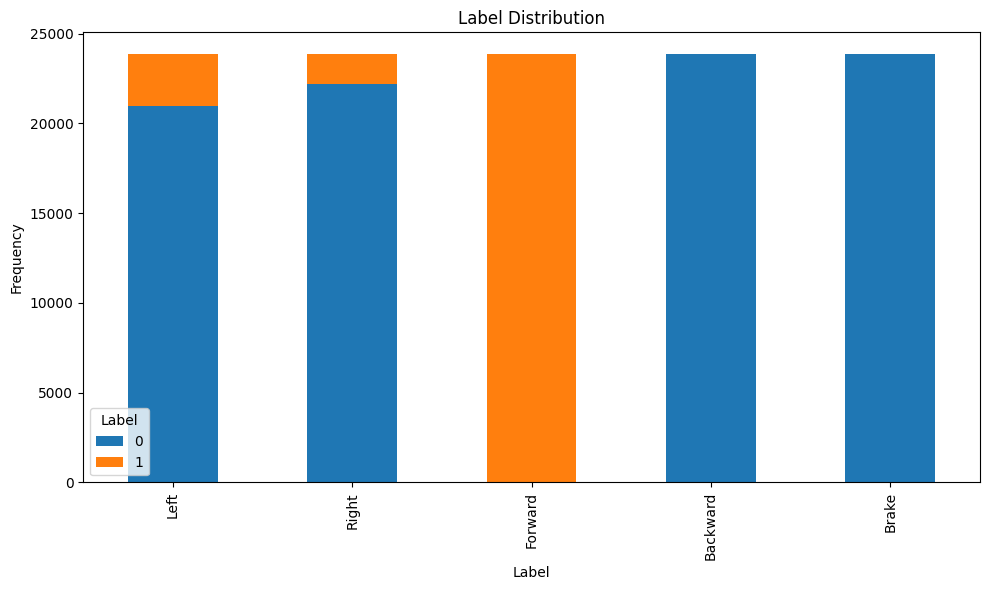

In [85]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [86]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [87]:
data['path'][0]

'outputs/training_data/10.jpeg'

In [88]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [89]:
images[0].shape

(64, 64, 3)

In [90]:
# mean = np.mean(images, axis=(0, 1, 2))
# std = np.std(images, axis=(0, 1, 2))
# scaled_images = (images - mean) / std

In [91]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [92]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_temp = X_temp / 255.0
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [93]:
len(X_train)

19106

In [94]:
len(X_test)

2389

In [95]:
X_train[0].shape

(64, 64, 3)

In [96]:
new = X_train[0] / 255.0

# Neural Network

## Model Set Up

In [97]:
optimizer = Adam(learning_rate=0.001)

In [98]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
        64, 64, 3)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    # layers.Conv2D(48, (3, 3), activation='relu'),
    # layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D(),
    # layers.BatchNormalization(),
    # layers.DropBlock2D(block_size=3, keep_prob=0.9),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='sigmoid')
])

In [99]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 31, 31, 32)        128       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3936384   
                                                                 
 dropout_1 (Dropout)         (None, 128)              

## Training Model

In [100]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [101]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
598/598 [==============================] - 17s 27ms/step - loss: 0.1049 - binary_accuracy: 0.9678 - val_loss: 0.0585 - val_binary_accuracy: 0.9765
Epoch 2/10
598/598 [==============================] - 18s 31ms/step - loss: 0.0377 - binary_accuracy: 0.9862 - val_loss: 0.0279 - val_binary_accuracy: 0.9890
Epoch 3/10
598/598 [==============================] - 17s 28ms/step - loss: 0.0248 - binary_accuracy: 0.9912 - val_loss: 0.0204 - val_binary_accuracy: 0.9921
Epoch 4/10
598/598 [==============================] - 19s 32ms/step - loss: 0.0163 - binary_accuracy: 0.9952 - val_loss: 0.0109 - val_binary_accuracy: 0.9958
Epoch 5/10
598/598 [==============================] - 17s 29ms/step - loss: 0.0111 - binary_accuracy: 0.9964 - val_loss: 0.0131 - val_binary_accuracy: 0.9961
Epoch 6/10
598/598 [==============================] - 16s 27ms/step - loss: 0.0100 - binary_accuracy: 0.9971 - val_loss: 0.0103 - val_binary_accuracy: 0.9969
Epoch 7/10
598/598 [==============================] 

## Testing Model

In [102]:
test_loss = model.evaluate(X_test, y_test)

75/75 [==============================] - 1s 8ms/step - loss: 0.0118 - binary_accuracy: 0.9965


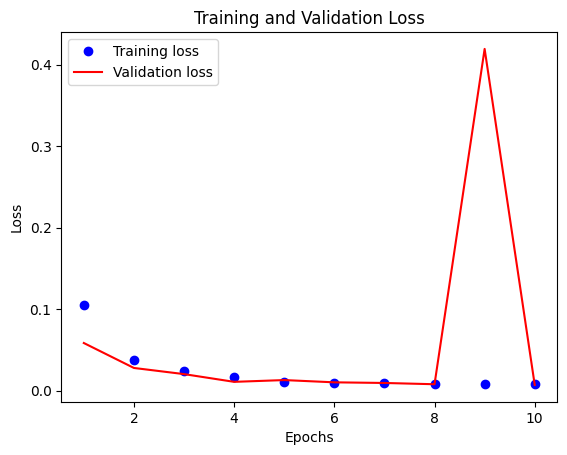

In [103]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
def convert_to_binary(floats, threshold=0.5):
    return [1 if x >= threshold else 0 for x in floats]

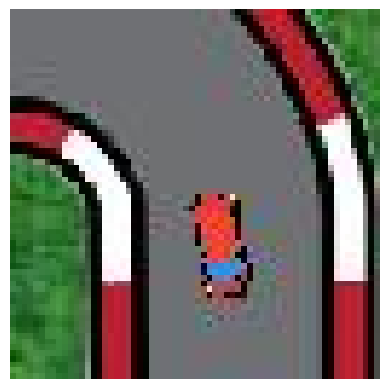

In [105]:
image = X_test[10]
plt.imshow(image)
plt.axis('off')
plt.show()

In [106]:
test_image = image.reshape(1, 64, 64, 3)
predictions = model.predict(test_image)
print(predictions[0])
binary_list = convert_to_binary(predictions[0])
print(binary_list)

1/1 [==============================] - 0s 39ms/step
[1.9877818e-15 6.3478284e-10 1.0000000e+00 4.8698123e-19]
[0, 0, 1, 0]


## Prediction Distribution

In [107]:
predictions_list = []
for num in range(250):
    image = X_test[num]
    test_image = image.reshape(1, 64, 64, 3)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 12ms/step


In [108]:
predictions_list

[array([[7.3628442e-08, 3.4362753e-08, 1.0000000e+00, 1.3869636e-17]],
       dtype=float32),
 array([[1.3856238e-04, 9.8912877e-01, 9.9999344e-01, 2.5051973e-05]],
       dtype=float32),
 array([[3.7745539e-07, 1.2964595e-09, 1.0000000e+00, 2.3047739e-10]],
       dtype=float32),
 array([[8.9779057e-08, 2.3762917e-08, 1.0000000e+00, 3.1110933e-10]],
       dtype=float32),
 array([[2.9695957e-05, 7.1371755e-06, 1.0000000e+00, 6.3124070e-09]],
       dtype=float32),
 array([[1.4737218e-04, 1.3204396e-09, 1.0000000e+00, 6.5369077e-15]],
       dtype=float32),
 array([[1.1778255e-04, 1.0722769e-05, 1.0000000e+00, 1.5217979e-09]],
       dtype=float32),
 array([[2.7261167e-06, 2.5040260e-08, 1.0000000e+00, 1.2912820e-09]],
       dtype=float32),
 array([[3.1396887e-06, 9.8770338e-01, 9.9999964e-01, 7.8018330e-09]],
       dtype=float32),
 array([[5.5873693e-06, 3.7402681e-10, 1.0000000e+00, 9.7036108e-17]],
       dtype=float32),
 array([[1.9877818e-15, 6.3478284e-10, 1.0000000e+00, 4.8698

## Activation Maps

In [109]:
for index, layer in enumerate(model.layers):
    print(f"Layer {index}: {layer.name}")

Layer 0: conv2d_2
Layer 1: max_pooling2d_2
Layer 2: batch_normalization_2
Layer 3: flatten_1
Layer 4: dense_2
Layer 5: dropout_1
Layer 6: dense_3


In [110]:
def generate_heatmap(image, model):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer('conv2d').output,
                 model.get_layer('dense_1').output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        predicted_class = np.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (64, 64))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = np.uint8(255 * image[0])
    superimposed_img = cv2.addWeighted(
        heatmap_color, 0.4, original_img, 0.6, 0)

    return superimposed_img, heatmap, heatmap_color

In [111]:
def calculate_mae(pred, true, threshold=0.5):
    pred = np.array(pred)
    true = np.array(true)

    # Apply threshold
    pred = (pred >= threshold).astype(int)
    true = (true >= threshold).astype(int)

    # Calculate absolute errors
    absolute_errors = np.abs(pred - true)
    mae = np.mean(absolute_errors)
    return mae

In [112]:
# Select and process images
num_images = 8
random_indices = np.random.choice(len(X_test), size=num_images, replace=False)

predictions = []
true_labels = []
images = []
mae = []
s_images = []
heatmaps = []
heatmap_colors = []

for i in random_indices:
    image = X_test[i].reshape(1, 64, 64, 3)
    pred = model.predict(image)[0]
    predictions.append(pred)
    mae.append(calculate_mae(pred, y_test[i]))
    true_labels.append(y_test[i])
    superimposed_img, heatmap, heatmap_color = generate_heatmap(image, model)
    s_images.append(superimposed_img)
    images.append(np.uint8(255 * X_test[i]))
    heatmaps.append(heatmap)
    heatmap_colors.append(heatmap_color)

1/1 [==============================] - 0s 12ms/step


ValueError: No such layer: conv2d. Existing layers are: ['conv2d_2', 'max_pooling2d_2', 'batch_normalization_2', 'flatten_1', 'dense_2', 'dropout_1', 'dense_3'].

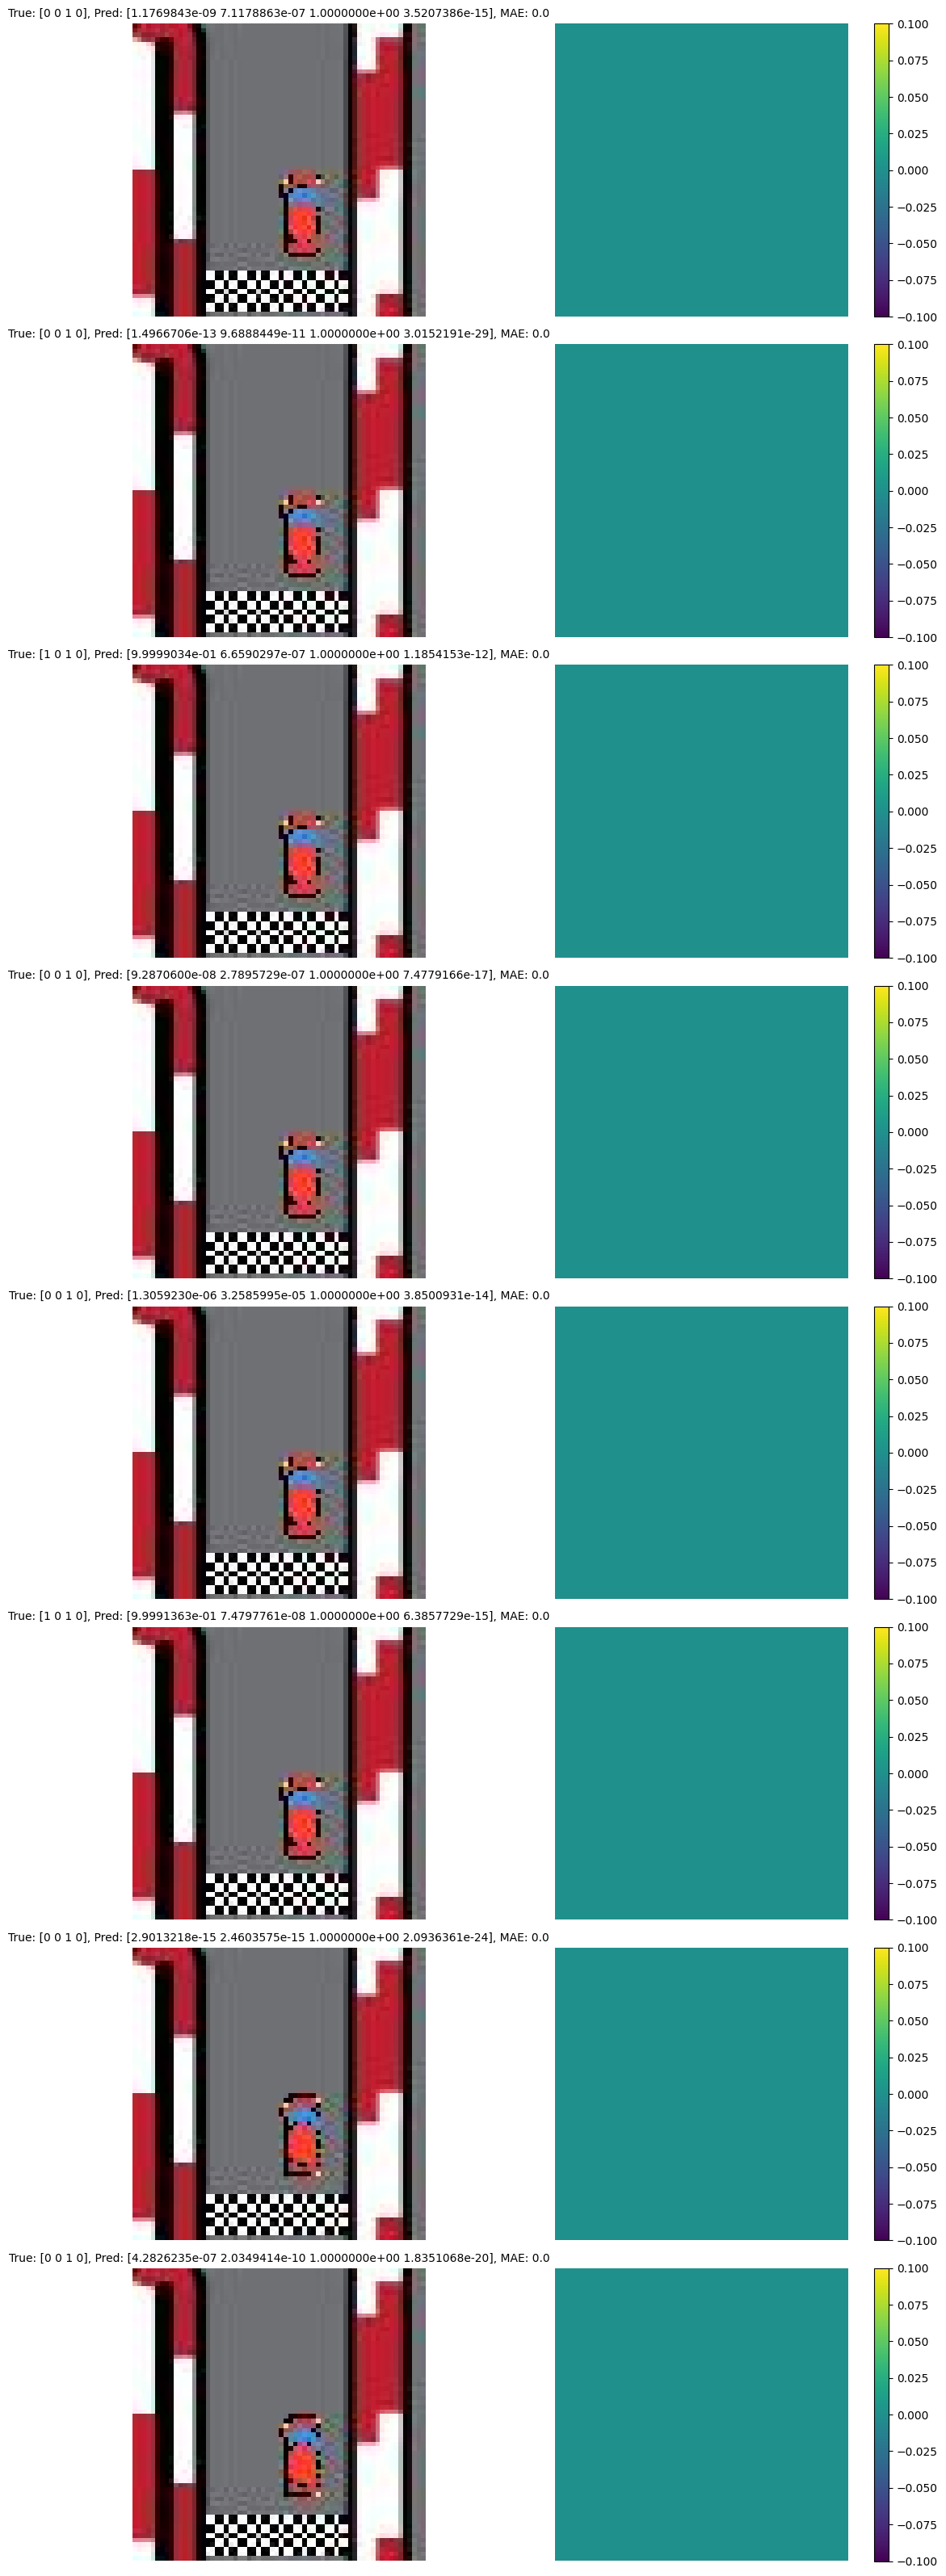

In [ ]:
fig, axes = plt.subplots(num_images, 2, figsize=(12, 4 * num_images))  # Increase figure size

for i in range(num_images):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    ax1.imshow(images[i])
    ax1.axis('off')
    ax1.set_title(
        f"True: {true_labels[i]}, Pred: {predictions[i]}, MAE: {mae[i]}", fontsize=10)

    # Display heatmap with colorbar
    im = ax2.imshow(heatmaps[i])
    ax2.axis('off')
    cbar = plt.colorbar(im, ax=ax2, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)  # Adjust colorbar size

plt.tight_layout()
plt.show()

## Saving Model Weights

In [ ]:
model.save("../models/CNN/ACT_GAME_4_RGB_conv2d0_dense1_0.3DO.h5")

/Users/andrew/Desktop/Projects/SelfDrivingCarSimulator/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
